In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from scipy.optimize import curve_fit
import plotly.graph_objects as go    
from scipy.optimize import fsolve
# 1. Descargar datos históricos del activo
activo = "AAPL"  # Ticker del activo
periodo = "1y"
datos = yf.Ticker(activo).history(period=periodo)

# 2. Calcular los retornos promedio (Average) y la desviación estándar (std)
datos['Average'] = datos[['High', 'Low']].mean(axis=1).pct_change()
datos['std'] = datos['Average'].rolling(window=5).std()

# Eliminar valores NaN para los ajustes
datos.dropna(inplace=True)

# --- MODELO POLINOMIAL ---
# Ajustar un modelo polinomial de grado 2
X_poly = np.column_stack((datos['Average'], datos['Average']**2))  # [x, x^2]
X_poly = sm.add_constant(X_poly)  # Añadir intercepto
modelo_poly = sm.OLS(datos['std'], X_poly).fit()

# Coeficientes del modelo polinomial
alpha_poly = modelo_poly.params[0]
beta_1_poly = modelo_poly.params[1]
beta_2_poly = modelo_poly.params[2]

# Predicciones del modelo polinomial
datos['std_pred_poly'] = alpha_poly + beta_1_poly * datos['Average'] + beta_2_poly * datos['Average']**2

# --- MODELO EXPONENCIAL DE GRADO 2 ---
# Definir la función exponencial de grado 2
def modelo_exponencial_grado2(x, alpha, beta1, beta2):
    return alpha * np.exp(beta1 * x + beta2 * x**2)

# Ajustar el modelo exponencial de grado 2
popt, _ = curve_fit(modelo_exponencial_grado2, datos['Average'], datos['std'], maxfev=10000)
alpha_exp2, beta1_exp2, beta2_exp2 = popt

# Predicciones del modelo exponencial de grado 2
datos['std_pred_exp2'] = modelo_exponencial_grado2(datos['Average'], alpha_exp2, beta1_exp2, beta2_exp2)

# --- GRAFICAR LOS RESULTADOS ---
fig = go.Figure()

# Datos observados
fig.add_trace(go.Scatter(x=datos['Average'], y=datos['std'],
                         mode='markers', name='Datos Observados',
                         marker=dict(size=8, color='blue', opacity=0.7)))

# Línea del modelo polinomial en el dominio delimitado
x_vals = np.linspace(-0.03, 0.075, 100)  # Dominio delimitado
y_vals_poly = alpha_poly + beta_1_poly * x_vals + beta_2_poly * x_vals**2
fig.add_trace(go.Scatter(x=x_vals, y=y_vals_poly, mode='lines', name='Modelo Polinomial (Grado 2)',
                         line=dict(color='red')))

# Línea del modelo exponencial de grado 2 en el dominio delimitado
y_vals_exp2 = modelo_exponencial_grado2(x_vals, alpha_exp2, beta1_exp2, beta2_exp2)
fig.add_trace(go.Scatter(x=x_vals, y=y_vals_exp2, mode='lines', name='Modelo Exponencial (Grado 2)',
                         line=dict(color='green')))

# Configuración del gráfico
fig.update_layout(title="Modelos Polinomial y Exponencial de Grado 2 (Dominio Delimitado)",
                  xaxis_title="Retornos Promedio (Average)",
                  yaxis_title="Desviación Estándar (std)",
                  template="plotly_white")

fig.show()

# --- RESULTADOS ---
print("Resultados del Modelo Polinomial:")
print(f"Intercepto (α): {alpha_poly:.4f}")
print(f"Coeficiente Lineal (β1): {beta_1_poly:.4f}")
print(f"Coeficiente Cuadrático (β2): {beta_2_poly:.4f}")
print(f"Resumen del Modelo Polinomial:\n{modelo_poly.summary()}")

print("\nResultados del Modelo Exponencial (Grado 2):")
print(f"Intercepto (α): {alpha_exp2:.4f}")
print(f"Coeficiente Lineal (β1): {beta1_exp2:.4f}")
print(f"Coeficiente Cuadrático (β2): {beta2_exp2:.4f}")


C:\Users\retir\AppData\Local\Temp\ipykernel_7992\969376187.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_poly = modelo_poly.params[0]
C:\Users\retir\AppData\Local\Temp\ipykernel_7992\969376187.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_1_poly = modelo_poly.params[1]
C:\Users\retir\AppData\Local\Temp\ipykernel_7992\969376187.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_2_poly = modelo_poly.par

Resultados del Modelo Polinomial:
Intercepto (α): 0.0103
Coeficiente Lineal (β1): -0.0087
Coeficiente Cuadrático (β2): 5.0658
Resumen del Modelo Polinomial:
                            OLS Regression Results                            
Dep. Variable:                    std   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     24.43
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.16e-10
Time:                        20:03:30   Log-Likelihood:                 883.12
No. Observations:                 246   AIC:                            -1760.
Df Residuals:                     243   BIC:                            -1750.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

Intersección 1: x = -0.0097, std = 0.0109
Intersección 2: x = -0.0097, std = 0.0109


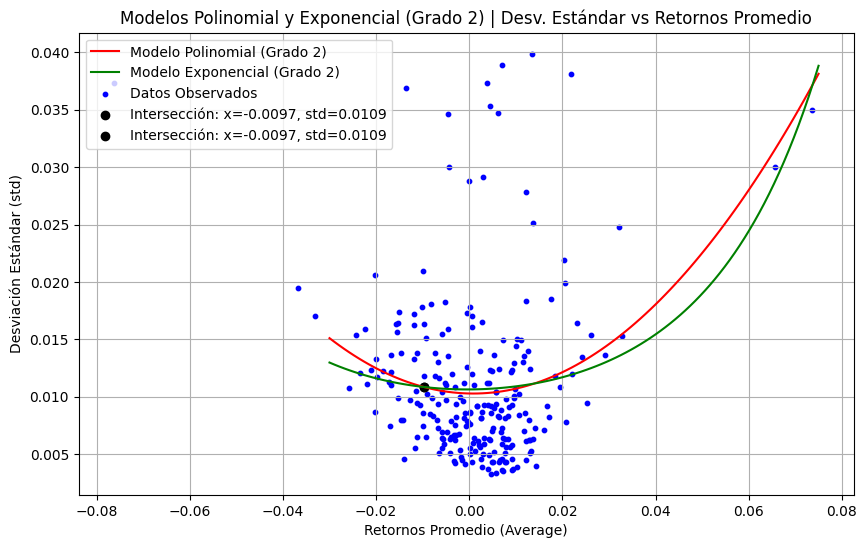

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from scipy.optimize import curve_fit
import plotly.graph_objects as go    
from scipy.optimize import fsolve

# Función para encontrar la intersección
def interseccion(x):
    std_poly = alpha_poly + beta_1_poly * x + beta_2_poly * x**2
    std_exp2 = alpha_exp2 * np.exp(beta1_exp2 * x + beta2_exp2 * x**2)
    return std_poly - std_exp2

# Valores iniciales para buscar las raíces
# valores_iniciales ya está definido en la celda anterior

# Resolver las raíces
intersecciones = [fsolve(interseccion, x0)[0] for x0 in valores_iniciales]

# Calcular las desviaciones estándar en las intersecciones
resultados = [(x, alpha_poly + beta_1_poly * x + beta_2_poly * x**2) for x in intersecciones]

# Mostrar los resultados
for i, (x, y) in enumerate(resultados):
    print(f"Intersección {i + 1}: x = {x:.4f}, std = {y:.4f}")

# Graficar las curvas y las intersecciones
x_vals = np.linspace(-0.03, 0.075, 100)
std_poly_vals = alpha_poly + beta_1_poly * x_vals + beta_2_poly * x_vals**2
std_exp2_vals = alpha_exp2 * np.exp(beta1_exp2 * x_vals + beta2_exp2 * x_vals**2)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, std_poly_vals, label="Modelo Polinomial (Grado 2)", color="red")
plt.plot(x_vals, std_exp2_vals, label="Modelo Exponencial (Grado 2)", color="green")
plt.scatter(datos['Average'], datos['std'], label="Datos Observados", color="blue", s=10)

# Marcar las intersecciones
for x, y in resultados:
    plt.scatter(x, y, color="black", label=f"Intersección: x={x:.4f}, std={y:.4f}")

plt.xlabel("Retornos Promedio (Average)")
plt.ylabel("Desviación Estándar (std)")
plt.title("Modelos Polinomial y Exponencial (Grado 2) | Desv. Estándar vs Retornos Promedio")
plt.legend()
plt.grid()
plt.show()
